In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [4]:
gc_df = pd.read_csv('future-gc00-daily-prices.csv',
                    parse_dates=['Date'],
                   dayfirst=False,
                   index_col='Date')

# Sort dataframe by the Date Index in ascending order
gc_df.sort_index(inplace=True)

In [6]:
gc_df

,Open,High,Low,Close
Date,,,,
2009-04-24,905.50,915.40,904.20,914.10
2009-04-27,915.00,919.70,905.80,908.20
2009-04-28,907.20,907.70,884.60,893.60
2009-04-29,894.00,904.00,888.30,900.50
2009-04-30,898.60,900.80,880.10,891.20
...,...,...,...,...
2024-02-02,"2,072.00","2,074.70","2,044.20","2,053.70"
2024-02-05,"2,057.90","2,059.10","2,030.80","2,042.90"
2024-02-06,"2,041.40","2,055.30","2,038.80","2,051.40"


In [14]:
gc_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3724 entries, 2009-04-24 to 2024-02-08
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Open    3724 non-null   object
 1   High    3724 non-null   object
 2   Low     3724 non-null   object
 3   Close   3724 non-null   object
dtypes: object(4)
memory usage: 145.5+ KB


In [18]:
gc_df = gc_df.replace(',', '', regex=True)

In [28]:
# Sice we are using the 'Close' column, we'll convert to int
gc_df['Close'] = pd.to_numeric(gc_df['Close'], errors='coerce')
gc_df["Close"].replace([np.inf, -np.inf], np.nan, inplace=True)
gc_df.dropna(subset=["Close"], inplace=True)

/tmp/ipykernel_32076/160089910.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gc_df["Close"].replace([np.inf, -np.inf], np.nan, inplace=True)


In [30]:
# check for missing values
gc_df.isnull().sum()

Open     0
High     0
Low      0
Close    0
dtype: int64

#### Visualization

##### Create a Time Plot

<function matplotlib.pyplot.show(close=None, block=None)>

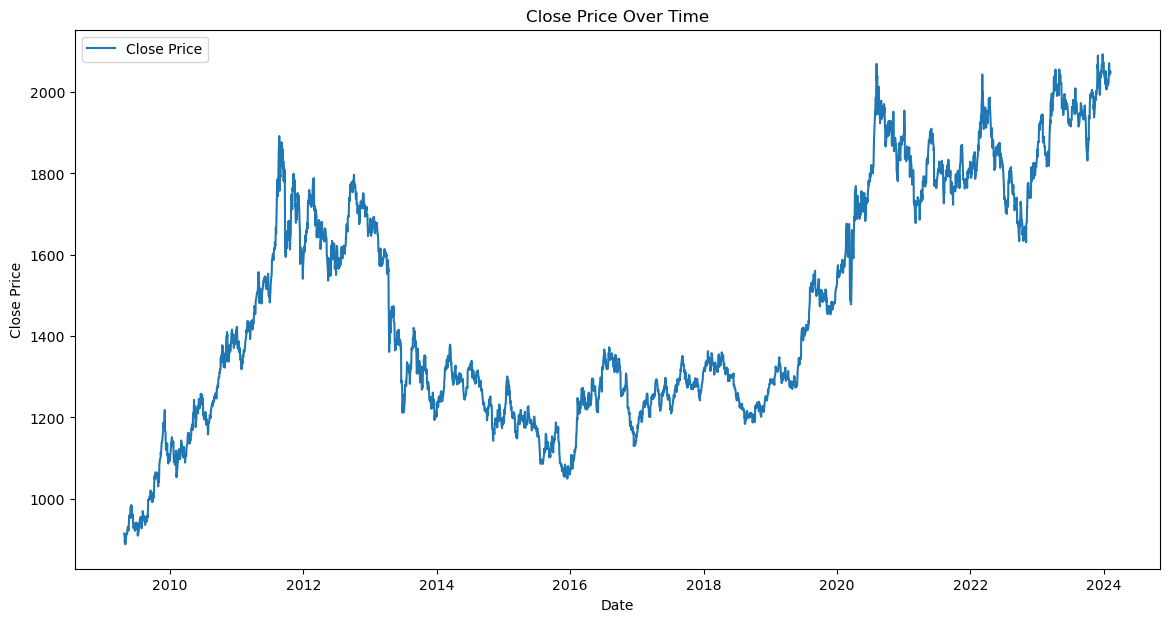

In [37]:
plt.figure(figsize=(14,7))
plt.plot(gc_df.index, gc_df['Close'], label='Close Price')
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show

##### Check for stationarity and perform differencing if necessary
Looking at the plot, above, we can see that the data is, in fact, not stationary because there is a clear trend.

In [47]:
# Check for stationarity
# Perform the Augmented Dickey-Fuller test on the original series
result_original = adfuller(gc_df["Close"])

print(f"ADF Statistic (Original): {result_original[0]:.4f}")
print(f"p-value (Original): {result_original[1]:.4f}")

if result_original[1] < 0.05:
    print("Interpretation: The original series is Stationary.\n")
else:
    print("Interpretation: The original series is Non-Stationary.\n")

# Apply first-order differencing
gc_df['Close_Diff'] = gc_df['Close'].diff()

# Perform the Augmented Dickey-Fuller test on the differenced series
result_diff = adfuller(gc_df["Close_Diff"].dropna())
print(f"ADF Statistic (Differenced): {result_diff[0]:.4f}")
print(f"p-value (Differenced): {result_diff[1]:.4f}")
if result_diff[1] < 0.05:
    print("Interpretation: The differenced series is Stationary.")
else:
    print("Interpretation: The differenced series is Non-Stationary.")

ADF Statistic (Original): -1.4367
p-value (Original): 0.5646
Interpretation: The original series is Non-Stationary.

ADF Statistic (Differenced): -19.1308
p-value (Differenced): 0.0000
Interpretation: The differenced series is Stationary.


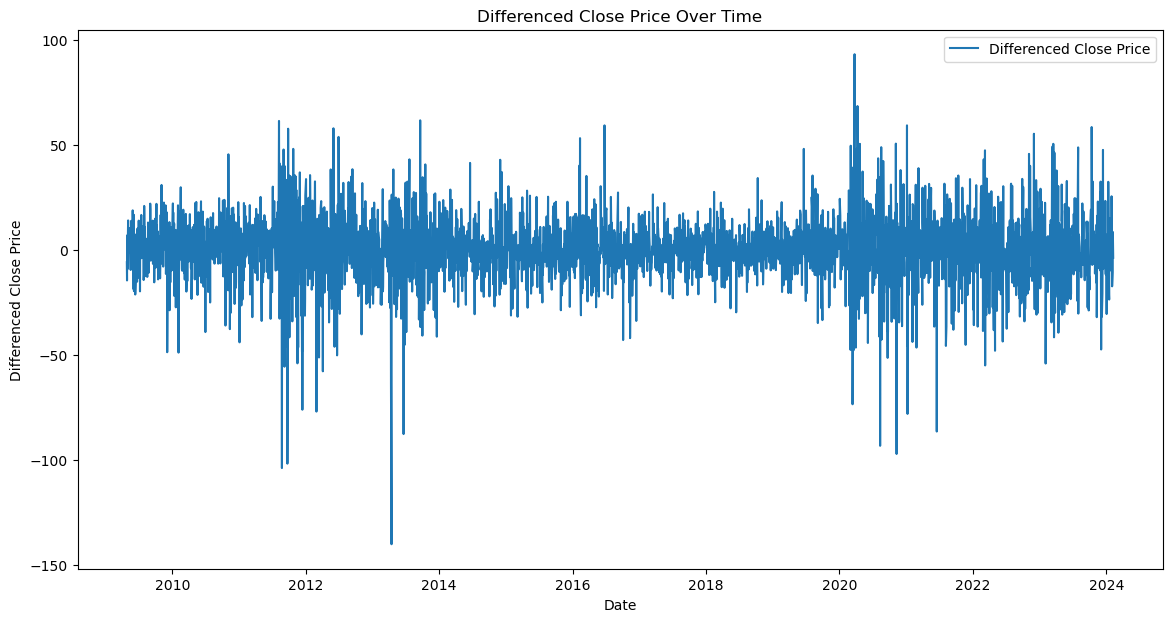

In [51]:
# Plotting the differenced Close price
plt.figure(figsize=(14, 7))
plt.plot(gc_df.index, gc_df['Close_Diff'], label='Differenced Close Price')
plt.title('Differenced Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()
plt.show()

#### Model Identification

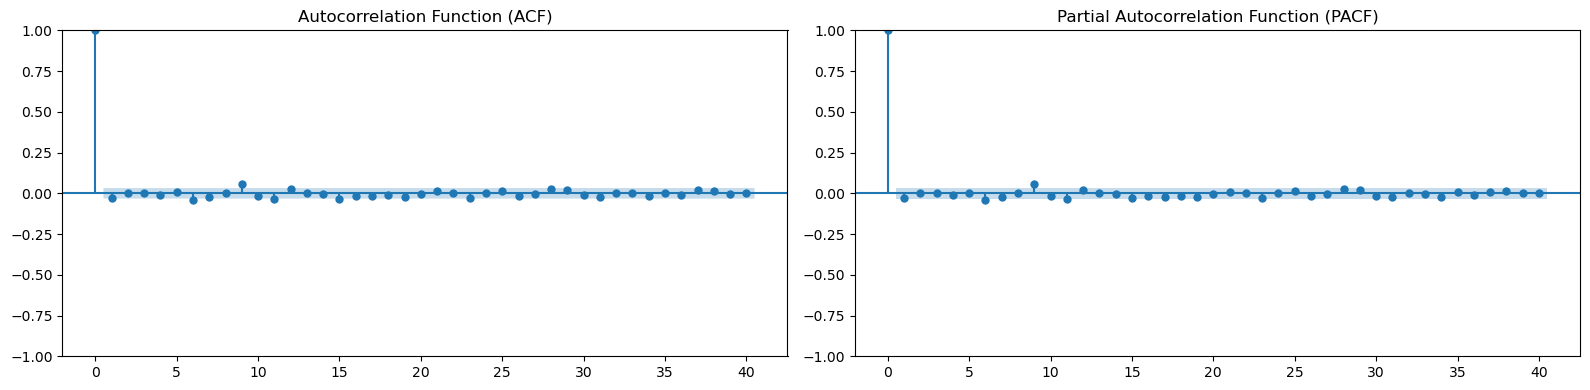

In [56]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF for the differenced series
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF plot
plot_acf(gc_df['Close_Diff'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(gc_df['Close_Diff'].dropna(), lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

#### Forecasting

In [59]:
# Split data into training and testing versions
train_size = int(len(gc_df) * 0.8)
train, test = gc_df.iloc[:train_size], gc_df.iloc[train_size:]

# Fit ARIMA model
model = ARIMA(train['Close'], order=(1,1,1))
model_fit = model.fit()

/home/karen/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/karen/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/karen/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


##### Visualize time series

/home/karen/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/karen/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


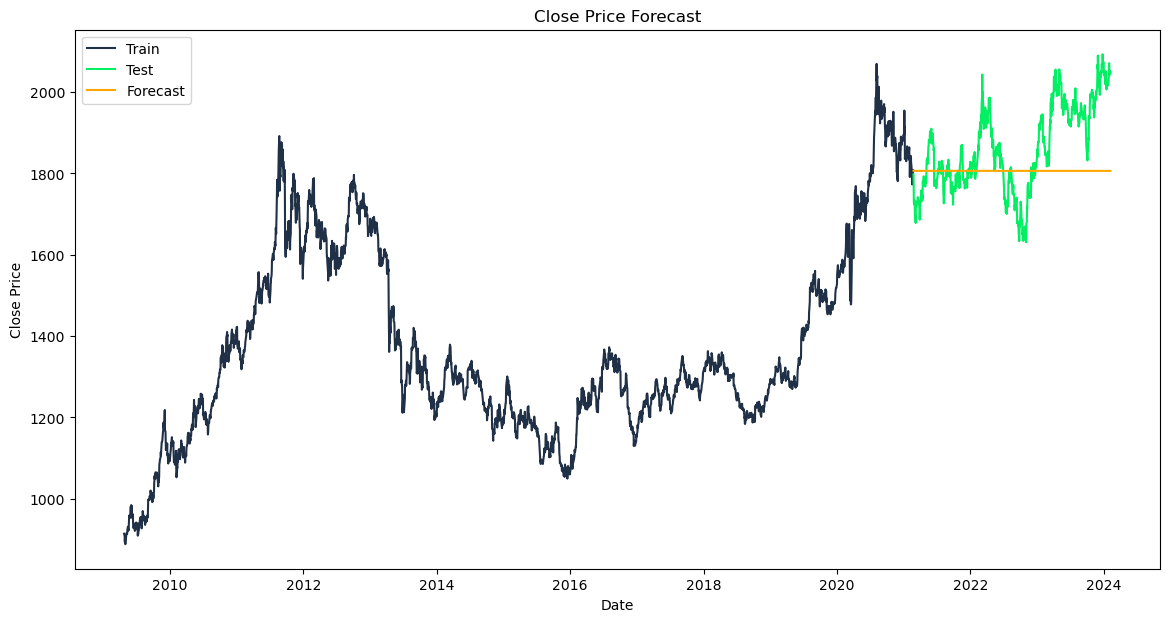

In [62]:
# Forecast
forecast = model_fit.forecast(steps=len(test))

# Plot the results with specified colors
plt.figure(figsize=(14,7))
plt.plot(train.index, train["Close"], label='Train', color='#203147')
plt.plot(test.index, test["Close"], label='Test', color='#01ef63')
plt.plot(test.index, forecast, label='Forecast', color='orange')
plt.title('Close Price Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

##### Evaluate Model Statistics

In [65]:
# Check AIC and BIC model statistics
print(f"AIC: {model_fit.aic}")
print(f"BIC: {model_fit.bic}")

AIC: 24602.974260664552
BIC: 24620.971282304283


In [67]:
# RMSE
forecast = forecast[:len(test)]
test_close = test["Close"][:len(forecast)]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_close, forecast))
print(f"RMSE: {rmse:.4f}")

RMSE: 118.5339
